In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


## Goal: Sentiment Analysis: Is this review positive or negative? 

In [2]:
#Load dataset
filepath = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(filepath)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
import re

def preprocess_text(text):
    """Cleans text by lowercasing, removing special characters, and splitting words."""
    text = text.lower()  # Lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    tokens = text.split()  # Simple tokenization (split by space)
    return " ".join(tokens)


In [4]:
df["cleaned_review"] = df["review"].apply(preprocess_text)
df[["review", "cleaned_review"]].head()

,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


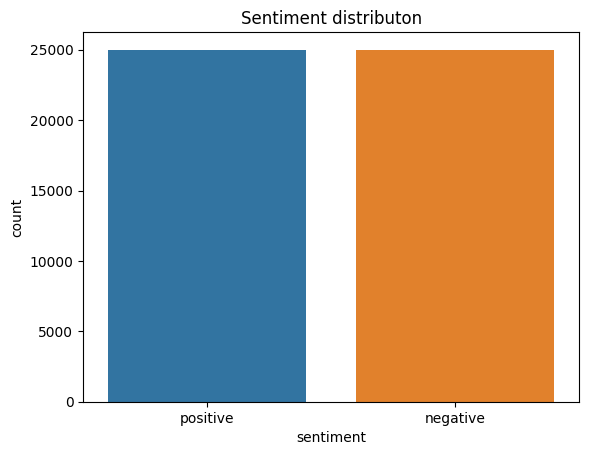

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.countplot(data= df, x='sentiment')
plt.title('Sentiment distributon')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X = df['review']  # Features (text data)
y = df['sentiment']  # Labels (target)

# Split the data into 80% training and 20% testing (you can adjust the test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create new DataFrames for training and testing
train_df = pd.DataFrame({'cleaned_review': X_train, 'sentiment': y_train})
test_df = pd.DataFrame({'cleaned_review': X_test, 'sentiment': y_test})

# Check the shape of your new DataFrames
print("Training set size:", train_df.shape)
print("Testing set size:", test_df.shape)

Training set size: (40000, 2)
Testing set size: (10000, 2)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Use bigrams for context

# Fit & transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["cleaned_review"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["cleaned_review"])

# Get labels
y_train = train_df["sentiment"].map({"positive": 1, "negative": 0})  # Convert labels to binary
y_test = test_df["sentiment"].map({"positive": 1, "negative": 0})

print("TF-IDF Matrix Shape:", X_train_tfidf.shape)

TF-IDF Matrix Shape: (40000, 5000)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression model
model_log = LogisticRegression(max_iter=1000)
model_log.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model_log.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8986

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [9]:
from sklearn.svm import LinearSVC

model_svm = LinearSVC()
model_svm.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model_svm.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8916

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      4961
           1       0.89      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Grid Search with cross-validation

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid for LinearSVC
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter, log scale from 1e-3 to 1e3
    'max_iter': [1000, 2000, 3000, 5000],  # Number of iterations for optimization
}

# Initialize the LinearSVC model
model_svm = LinearSVC()

# Initialize RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=model_svm, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', verbose=2, random_state=42)

# Fit the RandomizedSearchCV model
random_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best hyperparameters found: {best_params}")

# Train the model using the best hyperparameters
best_model = random_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAUC-ROC", )

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.09999999999999999, max_iter=2000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=2000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=2000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=2000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=2000; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=2000; total time=  14.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=2000; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=2000; total time=  14.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=2000; total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=2000; total time=  15.0s
[CV] END ...............C=0.09999999999999999, max_iter=1000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=1000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=1000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=1000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=1000; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=2000; total time=  12.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=2000; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=2000; total time=  12.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=2000; total time=  13.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=2000; total time=  12.7s
[CV] END .............................C=0.001, max_iter=1000; total time=   0.3s
[CV] END .............................C=0.001, max_iter=1000; total time=   0.3s
[CV] END .............................C=0.001, max_iter=1000; total time=   0.3s
[CV] END .............................C=0.001, max_iter=1000; total time=   0.3s
[CV] END .............................C=0.001, max_iter=1000; total time=   0.3s
[CV] END ...............................C=1.0, max_iter=1000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=1000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=1000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=1000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=1000; total time=   0.8s
[CV] END ..............................C=10.0, max_iter=2000; total time=   3.4s
[CV] END ...................

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=3000; total time=  17.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=3000; total time=  18.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=3000; total time=  17.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=3000; total time=  18.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .............................C=100.0, max_iter=3000; total time=  18.0s
[CV] END ...............C=0.09999999999999999, max_iter=5000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=5000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=5000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=5000; total time=   0.4s
[CV] END ...............C=0.09999999999999999, max_iter=5000; total time=   0.4s
[CV] END ...............................C=1.0, max_iter=2000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=2000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=2000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=2000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=2000; total time=   0.8s
[CV] END ...............................C=1.0, max_iter=5000; total time=   0.8s
[CV] END ...................

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=3000; total time=  19.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=3000; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=3000; total time=  20.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=3000; total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=3000; total time=  20.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=1000; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=1000; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=1000; total time=   9.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=1000; total time=   9.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............................C=1000.0, max_iter=1000; total time=   8.8s
Best hyperparameters found: {'max_iter': 2000, 'C': 0.09999999999999999}
Accuracy: 0.8982

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


AUC-ROC


#### 1. BiLSTM + GloVe Implementation 
Steps: 
1. Tokenize and pad sequences
2. Load GloVe embeddings
3. Build the BiLSTM model
4. Train and evaluate it
   

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


In [12]:
# Tokenization & Padding
MAX_NUM_WORDS = 20000  # Vocabulary size
MAX_SEQ_LENGTH = 200   # Maximum sequence length
EMBEDDING_DIM = 100    # Embedding dimension

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["cleaned_review"])

X_train_seq = tokenizer.texts_to_sequences(train_df["cleaned_review"])
X_test_seq = tokenizer.texts_to_sequences(test_df["cleaned_review"])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

In [13]:
# Build BiLSTM Model with Trainable Embeddings
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH, trainable=True),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile & Train
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.6843 - loss: 0.5815 - val_accuracy: 0.8501 - val_loss: 0.3586
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8669 - loss: 0.3305 - val_accuracy: 0.8820 - val_loss: 0.2818
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9256 - loss: 0.2031 - val_accuracy: 0.8837 - val_loss: 0.2812
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9544 - loss: 0.1400 - val_accuracy: 0.8846 - val_loss: 0.3065
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9722 - loss: 0.0897 - val_accuracy: 0.8642 - val_loss: 0.4237


In [14]:
# Predictions & Evaluation
y_pred_prob = model.predict(X_test_pad).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"BiLSTM - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, AUC-ROC: {auc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
BiLSTM - Accuracy: 0.8642, F1-score: 0.8554, AUC-ROC: 0.9475


In [15]:
import warnings
warnings.filterwarnings("ignore")

Load DistilBERT & Tokenizer

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Preprocess data

In [17]:
# Convert sentiment labels to binary (0 = negative, 1 = positive)
y_train_list = train_df["sentiment"].map({"positive": 1, "negative": 0}).tolist()
y_test_list = test_df["sentiment"].map({"positive": 1, "negative": 0}).tolist()

# Convert text data to lists
X_train_list = train_df["cleaned_review"].tolist()
X_test_list = test_df["cleaned_review"].tolist()

# Tokenize dataset
train_encodings = tokenizer(X_train_list, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(X_test_list, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
y_train_tensor = torch.tensor(y_train_list, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_list, dtype=torch.long)

# Create a custom dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create DataLoaders
train_dataset = SentimentDataset(train_encodings, y_train_tensor)
test_dataset = SentimentDataset(test_encodings, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Train the model

In [18]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_model(model, train_loader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

# Train the model
train_model(model, train_loader, optimizer, epochs=2)

Epoch 1/2, Loss: 0.23793082946573849
Epoch 2/2, Loss: 0.1298929678613902


Evaluate the model 

In [19]:
def evaluate_model(model, test_loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch["labels"].cpu().numpy())
    
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    
    print(f"Accuracy: {acc}")
    print(f"F1-Score: {f1}")
    print(f"AUC-ROC: {roc_auc}")
    return acc, f1, roc_auc

# Evaluate the trained model
evaluate_model(model, test_loader)

Accuracy: 0.9224
F1-Score: 0.9191666666666667
AUC-ROC: 0.9227681412137113


(0.9224, 0.9191666666666667, 0.9227681412137113)

Make predictions

In [20]:
def predict_sentiment(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
    
    return "Positive" if prediction == 1 else "Negative"

# Example texts
texts = [
    "I love this product! It works perfectly.",
    "This was the worst experience ever. I hate it.",
    "The movie was just okay, nothing special.",
    "I would definitely recommend this to my friends!"
]

# Predict sentiment
for text in texts:
    print(f"Text: {text} -> Sentiment: {predict_sentiment(text, model, tokenizer)}")

Text: I love this product! It works perfectly. -> Sentiment: Positive
Text: This was the worst experience ever. I hate it. -> Sentiment: Negative
Text: The movie was just okay, nothing special. -> Sentiment: Negative
Text: I would definitely recommend this to my friends! -> Sentiment: Positive
